In [3]:
!Cabocha -f1 data/neko.txt > work/neko.txt.cabocha

# 40. 係り受け解析結果の読み込み（形態素）

In [89]:
class Morph:
    def __init__(self, parse_result):
        morph = self._txt2morph(parse_result)
        self.surface = morph['surface']
        self.base = morph['base'] 
        self.pos = morph['pos'] 
        self.pos1 = morph['pos1']

    def _txt2morph(self, parse_result):
        splited_parse_result = parse_result.split('\t')
        splited_parse_result[1] = splited_parse_result[1].split(',')
        return {
            'surface':splited_parse_result[0],
            'base':splited_parse_result[1][6],
            'pos':splited_parse_result[1][0],
            'pos1':splited_parse_result[1][1]
        }
    
    def get_members_string(self):
        return f'surface : {self.surface}\tbase : {self.base}\tpos : {self.pos}\tpos1 : {self.pos1}'

In [90]:
def make_morph_sentence():
    with open('./work/neko.txt.cabocha', mode = 'r') as f:
        sentence = list() 
        for line in f:
            line = line.rstrip()
            if line == 'EOS':
                if sentence: yield sentence
                sentence = list()
                continue
            if line[0] == '*' and line[1] == ' ': continue
            sentence.append(Morph(line))

In [91]:
from itertools import islice

In [92]:
gen_morph_sentence = make_morph_sentence()
for sentence in islice(gen_morph_sentence, 2):
    for morph in sentence:
        print(morph.get_members_string())
    print()

surface : 一	base : 一	pos : 名詞	pos1 : 数

surface : 　	base : 　	pos : 記号	pos1 : 空白
surface : 吾輩	base : 吾輩	pos : 名詞	pos1 : 代名詞
surface : は	base : は	pos : 助詞	pos1 : 係助詞
surface : 猫	base : 猫	pos : 名詞	pos1 : 一般
surface : で	base : だ	pos : 助動詞	pos1 : *
surface : ある	base : ある	pos : 助動詞	pos1 : *
surface : 。	base : 。	pos : 記号	pos1 : 句点



# 41. 係り受け解析結果の読み込み（文節・係り受け）

In [93]:
from operator import itemgetter
from functools import reduce

In [94]:
'''
Class Chunk
文節のクラス
---Member---
morphs: 形態素のリスト 
dst: 係り先文節インデックス番号
srcs: 係り元文節インデックス番号のリスト
'''
class Chunk(Morph):
    def __init__(self):
        self.morphs = list()
        self.dst = -1
        self.srcs = list()
    
    def append_morph(self, parse_result):
        self.morphs.append(Morph(parse_result))
        
    def append_srcs(self, src):
        self.srcs.append(src)
    
    def set_dst(self, dst):
        self.dst = dst
    
    def get_members_string(self):
        morphs = reduce(lambda a, b: a + '(' + b.get_members_string() + ')\n', self.morphs, '')
        return f'morphs : \n{morphs}dst : {self.dst}\tsrcs : {self.srcs}'

    def morphs2string(self):
        return reduce(lambda a, b: a + (b.surface if b.pos != '記号' else ''), self.morphs, '')
    
    def check_pos(self, pos):
        for morph in self.morphs:
            if morph.pos == pos: return True
        return False

In [95]:
def make_chunk_sentence():
    with open('./work/neko.txt.cabocha', mode = 'r') as f:
        chunk_dict = dict()
        for line in f:
            line = line.rstrip()
            if line == 'EOS':
                sentence = [x[1] for x in sorted(chunk_dict.items(), key = itemgetter(0))]
                if sentence: yield sentence
                chunk_dict = dict()
                continue
            if line[0] == '*' and line[1] == ' ':
                splited_line = line.split()
                idx = int(splited_line[1])
                src = int(splited_line[2][:-1])
                if not idx in chunk_dict: chunk_dict[idx] = Chunk()
                if idx != -1: chunk_dict[idx].set_dst(src)
                if src != -1 and not src in chunk_dict: chunk_dict[src] = Chunk()
                if src != -1: chunk_dict[src].append_srcs(idx)
            else:
                chunk_dict[idx].append_morph(line)

In [96]:
gen_chunk_sentence = make_chunk_sentence()
for sentence in islice(gen_chunk_sentence, 2):
    for chunk in sentence:
        print(chunk.get_members_string())
    print()

morphs : 
(surface : 一	base : 一	pos : 名詞	pos1 : 数)
dst : -1	srcs : []

morphs : 
(surface : 　	base : 　	pos : 記号	pos1 : 空白)
dst : 2	srcs : []
morphs : 
(surface : 吾輩	base : 吾輩	pos : 名詞	pos1 : 代名詞)
(surface : は	base : は	pos : 助詞	pos1 : 係助詞)
dst : 2	srcs : []
morphs : 
(surface : 猫	base : 猫	pos : 名詞	pos1 : 一般)
(surface : で	base : だ	pos : 助動詞	pos1 : *)
(surface : ある	base : ある	pos : 助動詞	pos1 : *)
(surface : 。	base : 。	pos : 記号	pos1 : 句点)
dst : -1	srcs : [0, 1]



# 42. 係り元と係り先の文節の表示

In [97]:
gen_sentence = make_chunk_sentence()
for sentence in islice(gen_sentence, 7):
    for chunk in sentence:
        if chunk.dst != -1: print(f'{chunk.morphs2string()}\t{sentence[chunk.dst].morphs2string()}')
    print()


	猫である
吾輩は	猫である

名前は	無い
まだ	無い

どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ

何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している

吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た

しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ



# 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [98]:
noun_to_verb = list()
for sentence in make_chunk_sentence():
    for chunk in sentence:
        if chunk.dst == -1: continue
        if chunk.check_pos('名詞') and sentence[chunk.dst].check_pos('動詞'):
            noun_to_verb.append((chunk.morphs2string(), sentence[chunk.dst].morphs2string()))

In [99]:
for idx in range(5):
    print(noun_to_verb[idx])

('どこで', '生れたか')
('見当が', 'つかぬ')
('所で', '泣いて')
('ニャーニャー', '泣いて')
('いた事だけは', '記憶している')


# 44. 係り受け木の可視化

In [100]:
import pydot
from IPython.display import Image, display

In [101]:
graph = pydot.Dot(graph_type = 'digraph')
for sentence in islice(make_chunk_sentence(), 5, 6):
    for idx, chunk in enumerate(sentence):
        if chunk.dst == -1: continue
        id1 = idx
        id2 = chunk.dst
        label1 = chunk.morphs2string()
        label2 = sentence[id2].morphs2string()
        graph.add_node(pydot.Node(id1, label=label1))
        graph.add_node(pydot.Node(id2, label=label2))
        graph.add_edge(pydot.Edge(id1, id2))

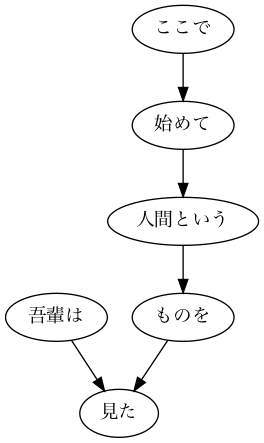

In [102]:
plt = Image(graph.create_png())
display(plt)
#graph.write_png('./work/result.png')

# 45. 動詞の格パターンの抽出

In [103]:
with open('./work/case_info.txt', mode = 'w') as out_file:
    for sentence in make_chunk_sentence():
        for chunk in sentence:
            verb = ''
            for morph in chunk.morphs:
                if morph.pos == '動詞':
                    verb = morph.base
                    break
            if verb:
                particle_list = list()
                for src in chunk.srcs:
                    src_chunk = sentence[src]
                    if src_chunk.morphs[-1].pos == '記号' and len(src_chunk.morphs) > 1: morph = src_chunk.morphs[-2]
                    else: morph = src_chunk.morphs[-1]
                    if morph.pos == '助詞':
                        particle_list.append(morph.base)
                if particle_list:
                    out_file.write(verb + '\t' + ' '.join(sorted(particle_list)) + '\n')

一文節内に複数の助詞がある場合どうすんnen(文節の最後に助詞が来ているもののみを抽出)

In [104]:
!cat ./work/case_info.txt | sort | uniq -c | sort -r | head -n 10 

    704 云う	と
    463 する	を
    336 思う	と
    205 ある	が
    203 なる	に
    193 する	に
    180 見る	て
    160 する	と
    118 する	が
    114 する	に を
sort: write failed: 'standard output': Broken pipe
sort: write error


In [105]:
!grep -E "^する|^見る|^与える" ./work/case_info.txt | sort | uniq -c | sort -r | head -n 10 

    463 する	を
    193 する	に
    180 見る	て
    160 する	と
    118 する	が
    114 する	に を
    100 見る	を
     90 する	は
     89 する	て を
     61 する	が を


In [106]:
!awk '{if(match($1, "^する|^見る|^与える")){print $0}}' ./work/case_info.txt | sort | uniq -c | sort -r | head -n 10

    463 する	を
    193 する	に
    180 見る	て
    160 する	と
    118 する	が
    114 する	に を
    100 見る	を
     90 する	は
     89 する	て を
     61 する	が を


# 46. 動詞の格フレーム情報の抽出

In [107]:
with open('./work/case_frame_info.txt', mode = 'w') as out_file:
    for sentence in make_chunk_sentence():
        for chunk in sentence:
            verb = ''
            for morph in chunk.morphs:
                if morph.pos == '動詞':
                    verb = morph.base
                    break
            if verb:
                particle_clause_list = list()
                for src in chunk.srcs:
                    src_chunk = sentence[src]
                    #最後の場所が助詞の場合のみ抽出(記号があった場合めんどくさ)
                    if src_chunk.morphs[-1].pos == '記号' and len(src_chunk.morphs) > 1: morph = src_chunk.morphs[-2]
                    else: morph = src_chunk.morphs[-1]
                    if morph.pos == '助詞':
                        particle_clause_list.append((morph.base, sentence[src].morphs2string()))
                if particle_clause_list:
                    sorted_particle_clause_list = sorted(particle_clause_list)
                    particle_list = [x[0] for x in sorted_particle_clause_list]
                    clause_list = [x[1] for x in sorted_particle_clause_list] 
                    out_file.write(verb + '\t' + ' '.join(particle_list) + '\t' + ' '.join(clause_list) + '\n')

助詞と同じ基準ってなんやねん(助詞でソート)

# 47. 機能動詞構文のマイニング

In [108]:
with open('./work/case_frame_util_info.txt', mode = 'w') as out_file:
    for sentence in make_chunk_sentence():
        for idx, chunk in enumerate(sentence):
            if len(chunk.morphs) == 2:
                morphs = chunk.morphs 
                if morphs[0].pos == '名詞' and morphs[0].pos1 == 'サ変接続' and morphs[1].surface == 'を' and morphs[1].pos == '助詞':
                    if chunk.dst != -1 and sentence[chunk.dst].check_pos('動詞'):
                        verb = ''
                        for morph in sentence[chunk.dst].morphs:
                            if morph.pos == '動詞':
                                verb = morph.base
                                break
                        particle_clause_list = list()
                        for src in sentence[chunk.dst].srcs:
                            if src == idx: continue
                            src_chunk = sentence[src]
                            if src_chunk.morphs[-1].pos == '記号' and len(src_chunk.morphs) > 1: morph = src_chunk.morphs[-2]
                            else: morph = src_chunk.morphs[-1]
                            if morph.pos == '助詞':
                                particle_clause_list.append((morph.base, sentence[src].morphs2string()))
                        if particle_clause_list:
                            sorted_particle_clause_list = sorted(particle_clause_list)
                            particle_list = [x[0] for x in sorted_particle_clause_list]
                            clause_list = [x[1] for x in sorted_particle_clause_list] 
                            out_file.write(chunk.morphs2string() + verb + '\t' + ' '.join(particle_list) + '\t' + ' '.join(clause_list) + '\n')

In [109]:
!cat ./work/case_frame_util_info.txt | cut -f 1 | sort | uniq -c | sort -r | head -n 10 

     25 返事をする
     19 挨拶をする
     11 話をする
      8 質問をする
      7 喧嘩をする
      6 真似をする
      5 質問をかける
      5 相談をする
      5 昼寝をする
      4 演説をする


In [110]:
!cat ./work/case_frame_util_info.txt | cut -f1,2 | sort | uniq -c | sort -r | head -n 10 

      6 返事をする	と
      4 挨拶をする	から
      4 返事をする	と は
      4 挨拶をする	と
      3 質問をかける	と は
      3 喧嘩をする	と
      2 同情を表する	て と は
      2 往来をあるく	て
      2 返事をする	から と
      2 挨拶をする	と も


# 48. 名詞から根へのパスの抽出

In [111]:
def rec(chunk, sentence, noun_path_idx):
    noun_path_idx.append(chunk.dst)
    if chunk.dst == -1: return
    rec(sentence[chunk.dst], sentence, noun_path_idx)

    
def noun_path_idx2noun_path(noun_path_idx, sentence):
    return [sentence[idx].morphs2string() for idx in noun_path_idx if idx != -1]

In [112]:
noun_path_list = list()
for sentence in islice(make_chunk_sentence(), 10):
    for idx, chunk in enumerate(sentence):
        if chunk.check_pos('名詞'):
            noun_path_idx = [idx]
            rec(chunk, sentence, noun_path_idx)
            noun_path_list.append(noun_path_idx2noun_path(noun_path_idx, sentence))

In [113]:
for idx in range(20):
    noun_path = noun_path_list[idx]
    print(' -> '.join(noun_path))

一
吾輩は -> 猫である
猫である
名前は -> 無い
どこで -> 生れたか -> つかぬ
見当が -> つかぬ
何でも -> 薄暗い -> 所で -> 泣いて -> 記憶している
所で -> 泣いて -> 記憶している
ニャーニャー -> 泣いて -> 記憶している
いた事だけは -> 記憶している
記憶している
吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た
あとで -> 聞くと -> 種族であったそうだ
それは -> 種族であったそうだ
書生という -> 人間中で -> 種族であったそうだ
人間中で -> 種族であったそうだ
一番 -> 獰悪な -> 種族であったそうだ


# 49. 名詞間の係り受けパスの抽出

In [114]:
def mask(chunk, mask_char):
    masked_string = ''
    for morph in chunk.morphs:
        if morph.pos == '名詞':
            masked_string += mask_char
        else:
            if morph.pos == '記号': continue
            masked_string += morph.surface
    return masked_string

In [115]:
noun_to_noun_path_list = list()
for sentence in make_chunk_sentence():
    for x_idx, x_chunk in enumerate(sentence):
        if not x_chunk.check_pos('名詞'): continue
        for y_idx, y_chunk in enumerate(sentence[x_idx + 1:]):
            y_idx += x_idx + 1
            if not y_chunk.check_pos('名詞'): continue
            x_noun_path_idx = [x_idx]
            rec(x_chunk, sentence, x_noun_path_idx)
            y_noun_path_idx = [y_idx]
            rec(y_chunk, sentence, y_noun_path_idx)
            while x_noun_path_idx and y_noun_path_idx and x_noun_path_idx[-1] == y_noun_path_idx[-1]:
                x_noun = x_noun_path_idx.pop(-1)
                y_noun = y_noun_path_idx.pop(-1)
            if y_noun_path_idx:
                out_str = ''
                x_noun_path = noun_path_idx2noun_path(x_noun_path_idx, sentence)
                x_noun_path[0] = mask(x_chunk, 'X')
                out_str += ' -> '.join(x_noun_path) + ' | '
                y_noun_path = noun_path_idx2noun_path(y_noun_path_idx, sentence)
                y_noun_path[0] = mask(y_chunk, 'Y')
                out_str += ' -> '.join(y_noun_path) + ' | '
                out_str += sentence[x_noun].morphs2string()
                noun_to_noun_path_list.append(out_str)
            else:
                out_str = ''
                x_noun_path = noun_path_idx2noun_path(x_noun_path_idx, sentence)
                x_noun_path[0] = mask(x_chunk, 'X')
                x_noun_path.append(mask(y_chunk, 'Y'))
                out_str += ' -> '.join(x_noun_path)
                noun_to_noun_path_list.append(out_str)

In [116]:
for idx in range(30):
    print(noun_to_noun_path_list[idx])

Xは -> Yである
Xで -> 生れたか | Yが | つかぬ
Xでも -> 薄暗い -> Yで
Xでも -> 薄暗い -> 所で | Y | 泣いて
Xでも -> 薄暗い -> 所で -> 泣いて | Yだけは | 記憶している
Xでも -> 薄暗い -> 所で -> 泣いて -> Yしている
Xで | Y | 泣いて
Xで -> 泣いて | Yだけは | 記憶している
Xで -> 泣いて -> Yしている
X -> 泣いて | Yだけは | 記憶している
X -> 泣いて -> Yしている
Xだけは -> Yしている
Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Yという
Xで -> 始めて -> 人間という -> Yを
Xという -> Yを
Xで -> 聞くと | Yは | 種族であったそうだ
Xで -> 聞くと | Yという -> 人間中で | 種族であったそうだ
Xで -> 聞くと | YYで | 種族であったそうだ
Xで -> 聞くと | Y -> 獰悪な | 種族であったそうだ
Xで -> 聞くと | Yな | 種族であったそうだ
Xで -> 聞くと -> YであったYだ
Xは | Yという -> 人間中で | 種族であったそうだ
Xは | YYで | 種族であったそうだ
Xは | Y -> 獰悪な | 種族であったそうだ
Xは | Yな | 種族であったそうだ
Xは -> YであったYだ
Xという -> YYで


逆方向に係らないからi < jでおけ   
名詞句が複数ある場合のマスクどうすんnen